In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.geocoders import Nominatim
from IPython.display import HTML
pd.set_option('display.max_columns',0)
pd.set_option('display.width',1000)
pd.set_option('max_colwidth', None)

In [10]:
accel = (r"C:\Users\ph108486\Documents\RM004064_accel\accel_investigation\rawdata\accel.csv")
braking = (r"C:\Users\ph108486\Documents\RM004064_accel\accel_investigation\rawdata\braking.csv")
equipment_status_fpath = (r"C:\Users\ph108486\Documents\RM004064_accel\accel_investigation\rawdata\Equipment_Status_Log_08_07_2024.csv")

In [11]:
df = pd.read_csv(accel)
df2 = pd.read_csv(braking)
df3 = pd.read_csv(equipment_status_fpath)

In [12]:
df.head()

,Device,Device Group,First Name,Last Name,Driver,Driver Group,Rule,Location,Location Zone Types,Date,Start Time,Duration,Distance,Extra Info,Details,Status,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 984,Unnamed: 985,Unnamed: 986,Unnamed: 987,Unnamed: 988,Unnamed: 989,Unnamed: 990,Unnamed: 991,Unnamed: 992,Unnamed: 993,Unnamed: 994,Unnamed: 995,Unnamed: 996,Unnamed: 997,Unnamed: 998,Unnamed: 999,Unnamed: 1000,Unnamed: 1001,Unnamed: 1002,Unnamed: 1003,Unnamed: 1004,Unnamed: 1005,Unnamed: 1006,Unnamed: 1007,Unnamed: 1008,Unnamed: 1009,Unnamed: 1010,Unnamed: 1011,Unnamed: 1012,Unnamed: 1013,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
0,RM004064,"Vehicle, IFTA, Diesel, TRUCK FLATBED, SDNEW / #0520",Brandon,Bishop,104430,SDNEW / #0520,Hard Acceleration,"SD FAYETTEVILLE (GA) / ASFAY / #0130 150 Air_Mile, SD LITHIA SPRINGS / SDLIS / #0527 150 Air_Mile, SU ALBANY / SUALB / #0786 150 Air_Mile, SR PENSACOLA / SRPEN / #0556 150 Air_Mile, SD NEWNAN / SDNEW / #0520 150 Air_Mile, SD CARTERSVILLE / SDKEN / #0518 150 Air_Mile: I-65, Montgomery, AL 36104, USA","150_Air_Miles, Customer Zone","May 01, 2024",11:22:22 AM,0:00,0.0,"Hard Acceleration (Max Speed: 62 mph Ignition: 1.00 , Acceleration forward or braking: 2.61 G force)","Hard Acceleration (Max Speed: 62 mph Ignition: 1.00 , Acceleration forward or braking: 2.61 G force)",Valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RM004064,"Vehicle, IFTA, Diesel, TRUCK FLATBED, SDNEW / #0520",Brandon,Bishop,104430,SDNEW / #0520,Hard Acceleration,"SD FAYETTEVILLE (GA) / ASFAY / #0130 150 Air_Mile, SD LITHIA SPRINGS / SDLIS / #0527 150 Air_Mile, SU ALBANY / SUALB / #0786 150 Air_Mile, SR PENSACOLA / SRPEN / #0556 150 Air_Mile, SD NEWNAN / SDNEW / #0520 150 Air_Mile, SD CARTERSVILLE / SDKEN / #0518 150 Air_Mile: I-65, Montgomery, AL 36104, USA","150_Air_Miles, Customer Zone","May 01, 2024",11:22:22 AM,0:00,0.0,"Hard Acceleration (Max Speed: 62 mph Ignition: 1.00 , Acceleration forward or braking: 0.42 G force)","Hard Acceleration (Max Speed: 62 mph Ignition: 1.00 , Acceleration forward or braking: 0.42 G force)",Valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RM004064,"Vehicle, IFTA, Diesel, TRUCK FLATBED, SDNEW / #0520",Brandon,Bishop,104430,SDNEW / #0520,Hard Acceleration,"SD FAYETTEVILLE (GA) / ASFAY / #0130 150 Air_Mile, SD LITHIA SPRINGS / SDLIS / #0527 150 Air_Mile, SU ALBANY / SUALB / #0786 150 Air_Mile, SR PENSACOLA / SRPEN / #0556 150 Air_Mile, SD NEWNAN / SDNEW / #0520 150 Air_Mile, SD CARTERSVILLE / SDKEN / #0518 150 Air_Mile: I-65, Montgomery, AL 36104, USA","150_Air_Miles, Customer Zone","May 01, 2024",11:22:22 AM,0:00,0.0,"Hard Acceleration (Max Speed: 62 mph Ignition: 1.00 , Acceleration forward or braking: 3.11 G force)","Hard Acceleration (Max Speed: 62 mph Ignition: 1.00 , Acceleration forward or braking: 3.11 G force)",Valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RM004064,"Vehicle, IFTA, Diesel, TRUCK FLATBED, SDNEW / #0520",Brandon,Bishop,104430,SDNEW / #0520,Hard Acceleration,"SD FAYET

In [13]:
df3.head()

,Equipment ID,Equipment Description,Equipment Status,VIN/Serial #,In Service Date,Branch ID,Company,Equipment
0,AD112583,TRUCK TRACTOR SLEEPER,Active,1XPVD09X1AD112583,07/13/2020,ALLLH,SRS Distribution,AD112583 - TRUCK TRACTOR SLEEPER
1,PD785499,TRUCK TRACTOR SLEEPER,Active,1XPBDP9X6PD785499,06/09/2022,BSLDFW,Building Supply Logistics,PD785499 - TRUCK TRACTOR SLEEPER
2,RD648578,TRUCK TRACTOR SLEEPER,Active,1XPBDP9X4RD648578,06/26/2023,BSLDFW,Building Supply Logistics,RD648578 - TRUCK TRACTOR SLEEPER
3,PD785505,TRUCK TRACTOR SLEEPER,Active,1XPBDP9X8PD785505,01/06/2023,BSLDFW,SRS Distribution,PD785505 - TRUCK TRACTOR SLEEPER
4,ND785530,TRUCK TRACTOR SLEEPER,Active,1XPBDP9X0ND785530,11/09/2021,BSLDFW,Building Supply Logistics,ND785530 - TRUCK TRACTOR SLEEPER


In [14]:
df['branch_number'] = df['Device Group'].str.extract(r'(\d{4})$')
df2['branch_number'] = df2['Device Group'].str.extract(r'(\d{4})$')

In [15]:
df_selected = df[['Device','Rule','Date','Start Time','Distance','Details','branch_number','First Name', 'Last Name']]
df2_selected = df2[['Device','Rule', 'Date','Start Time','Distance','Details','branch_number','First Name', 'Last Name']]
df3_selected = df3[['Equipment ID','Equipment Description','Equipment Status','In Service Date','Branch ID','Company']]

In [16]:
accel_merged_df = df_selected.merge(df3_selected, left_on='Device', right_on='Equipment ID', how='left')
brake_merged_df = df2_selected.merge(df3_selected, left_on='Device', right_on='Equipment ID', how='left')

In [17]:
accel_merged_df['g_force'] = accel_merged_df['Details'].str.extract(r'Acceleration forward or braking: (\d+\.\d+) G force').astype(float)
accel_merged_df['max_speed'] = accel_merged_df['Details'].str.extract(r'Max Speed: (\d+) mph').astype(int)
accel_merged_df['ignition'] = accel_merged_df['Details'].str.extract(r'Ignition: (\d+)').astype(float)

brake_merged_df['g_force'] = brake_merged_df['Details'].str.extract(r'Acceleration forward or braking: (-?\d+\.\d+) G force').astype(float)
brake_merged_df['max_speed'] = brake_merged_df['Details'].str.extract(r'Max Speed: (\d+) mph').astype(int)
brake_merged_df['ignition'] = brake_merged_df['Details'].str.extract(r'Ignition: (\d+)').astype(float)

In [18]:
accel_merged_df['driver_name'] = accel_merged_df['First Name'] + ' ' + accel_merged_df['Last Name']

In [19]:
rename_dict = {'Device':'device',
               'Rule':'rule',
               'Location':'location',
               'Date':'date',
               'Start Time':'start_time',
               'Distance':'distance',
               'Equipment ID':'equipment_id',
               'Equipment Description':'equipment_description',
               'Equipment Status':'equipment_status',
               'In Service Date':'in_service_date',
               'Branch ID':'branch_id',
               'Company':'company',
               'Details':'details'
               }

In [20]:
accel_merged_df = accel_merged_df.rename(columns=rename_dict)
brake_merged_df = brake_merged_df.rename(columns=rename_dict)

In [21]:
accel_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device                 739 non-null    object 
 1   rule                   739 non-null    object 
 2   date                   739 non-null    object 
 3   start_time             739 non-null    object 
 4   distance               739 non-null    float64
 5   details                739 non-null    object 
 6   branch_number          739 non-null    object 
 7   First Name             739 non-null    object 
 8   Last Name              739 non-null    object 
 9   equipment_id           739 non-null    object 
 10  equipment_description  739 non-null    object 
 11  equipment_status       739 non-null    object 
 12  in_service_date        739 non-null    object 
 13  branch_id              739 non-null    object 
 14  company                739 non-null    object 
 15  g_forc

In [22]:
cols_to_drop = {'First Name', 'Last Name', 'details','distance','start_time'}

In [23]:
accel_merged_df.drop(columns=cols_to_drop, inplace=True)

In [24]:
accel_merged_df['date'] = pd.to_datetime(accel_merged_df['date'], format = '%b %d, %Y')
brake_merged_df['date'] = pd.to_datetime(brake_merged_df['date'], format = '%b %d, %Y')

In [25]:
accel_merged_df = accel_merged_df.drop(accel_merged_df[accel_merged_df['g_force'] > 1].index)
brake_merged_df = brake_merged_df.drop(brake_merged_df[brake_merged_df['g_force'] < -1.5].index)

In [26]:
accel_merged_df['g_force'].value_counts()

g_force
0.39    75
0.40    57
0.42    53
0.38    52
0.41    51
0.43    41
0.46    36
0.45    25
0.44    25
0.50    14
0.47    14
0.48    13
0.51    11
0.49     9
0.52     6
0.53     6
0.54     4
0.56     3
0.55     2
0.61     2
0.60     1
Name: count, dtype: int64

In [27]:
brake_merged_df['g_force'].value_counts()

g_force
-0.56    5
-0.61    4
-0.59    4
-0.58    3
-0.60    3
-1.34    3
-1.21    3
-0.90    2
-1.32    2
-0.64    2
-1.13    2
-1.09    2
-1.49    2
-1.27    2
-0.62    2
-1.14    2
-0.72    2
-1.42    2
-0.99    2
-0.57    2
-0.95    1
-1.01    1
-1.22    1
-1.48    1
-1.10    1
-1.25    1
-0.83    1
-1.12    1
-1.33    1
-1.41    1
-0.65    1
-0.82    1
-1.37    1
-1.29    1
-1.18    1
-0.98    1
-1.26    1
-1.44    1
-0.68    1
-0.93    1
-1.07    1
-1.30    1
-1.00    1
Name: count, dtype: int64

In [28]:
accel_merged_df['month'] = accel_merged_df['date'].dt.strftime('%b')
brake_merged_df['month'] = brake_merged_df['date'].dt.strftime('%b')

In [29]:
monthly_counts = accel_merged_df['month'].agg({'count': 'sum'})

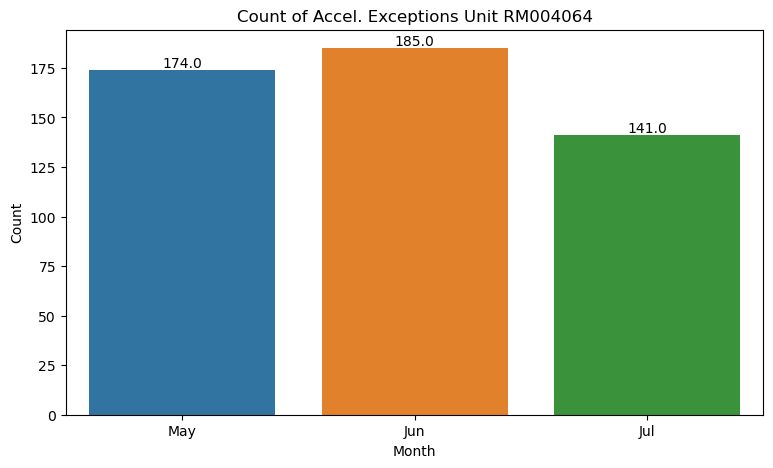

In [39]:
plt.figure(figsize=(9,5))
ax = sns.countplot(data=accel_merged_df, x='month')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
ax.set_title('Count of Accel. Exceptions Unit RM004064')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.savefig('accel')

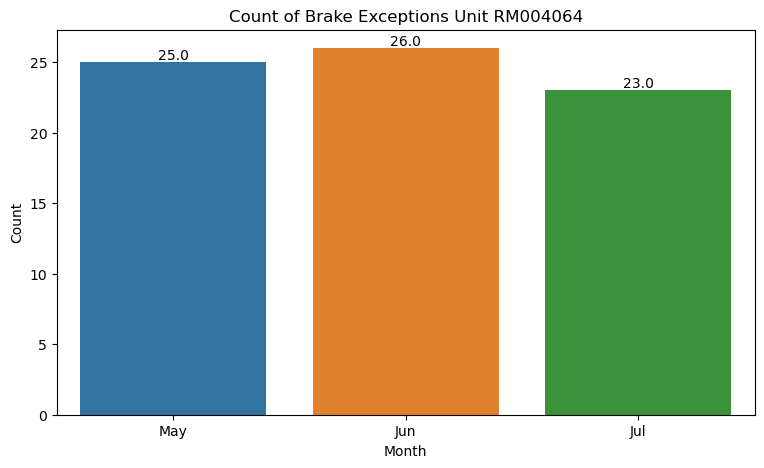

In [40]:
plt.figure(figsize=(9,5))
ax = sns.countplot(data=brake_merged_df, x='month')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
ax.set_title('Count of Brake Exceptions Unit RM004064')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
plt.savefig('brake')

In [32]:
brake_merged_df['month'].value_counts()

month
Jun    26
May    25
Jul    23
Name: count, dtype: int64

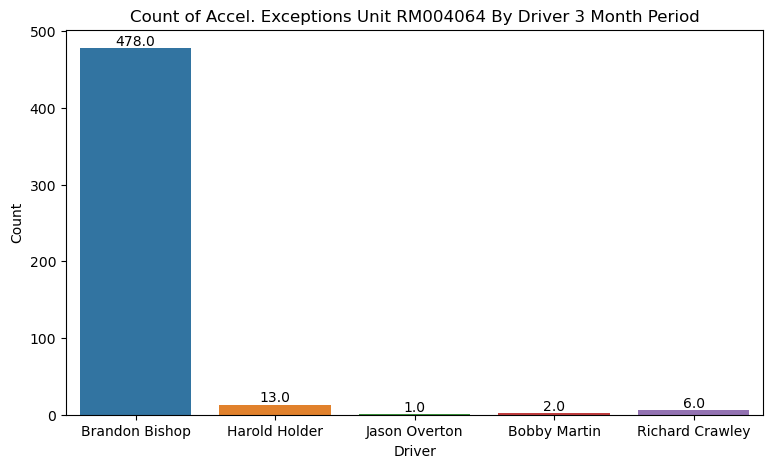

In [41]:
plt.figure(figsize=(9,5))
ax = sns.countplot(data=accel_merged_df, x='driver_name')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
ax.set_title('Count of Accel. Exceptions Unit RM004064 By Driver 3 Month Period')
ax.set_xlabel('Driver')
ax.set_ylabel('Count')
plt.savefig('accel_by_driver')

In [34]:
may_accel_merged_df = accel_merged_df[accel_merged_df['date'].dt.month == 5]
june_accel_merged_df = accel_merged_df[accel_merged_df['date'].dt.month == 6]
july_accel_merged_df = accel_merged_df[accel_merged_df['date'].dt.month == 7]

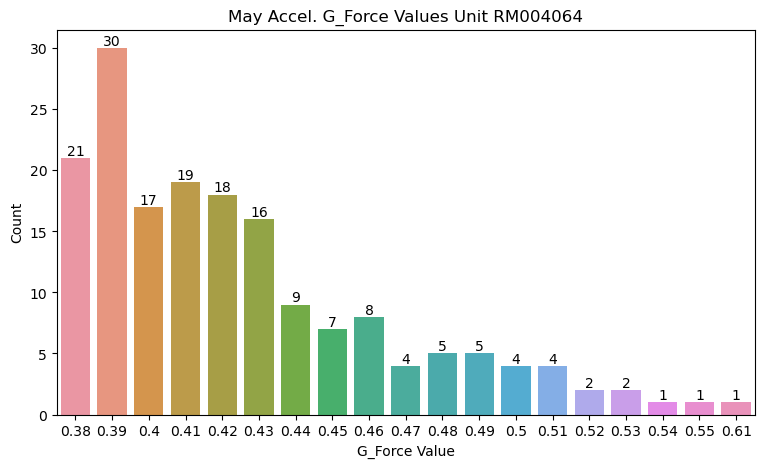

In [42]:
plt.figure(figsize=(9,5))
ax = sns.countplot(data=may_accel_merged_df, x='g_force')

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
ax.set_title('May Accel. G_Force Values Unit RM004064')
ax.set_xlabel('G_Force Value')
ax.set_ylabel('Count')
plt.savefig('may_gforce')

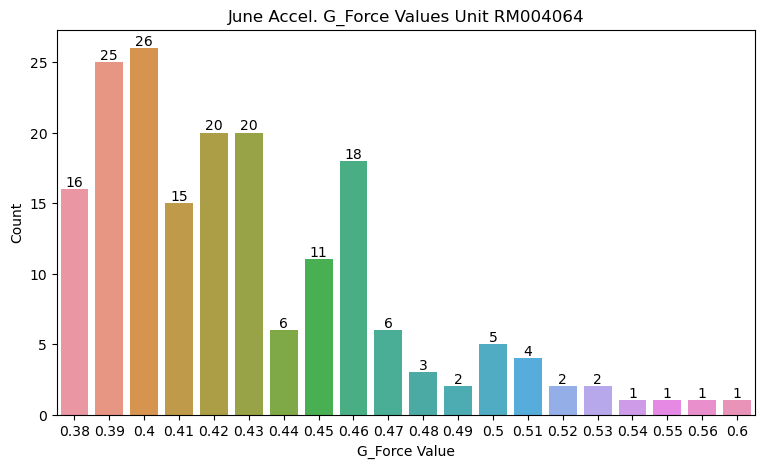

In [43]:
plt.figure(figsize=(9,5))
ax = sns.countplot(data=june_accel_merged_df, x='g_force')

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
ax.set_title('June Accel. G_Force Values Unit RM004064')
ax.set_xlabel('G_Force Value')
ax.set_ylabel('Count')
plt.savefig('june_gforce')

Text(0, 0.5, 'Count')

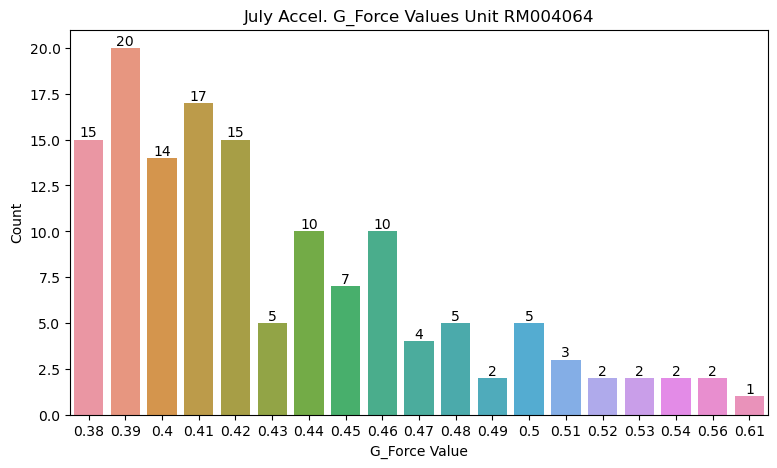

In [37]:
plt.figure(figsize=(9,5))
ax = sns.countplot(data=july_accel_merged_df, x='g_force')

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Add titles and labels
ax.set_title('July Accel. G_Force Values Unit RM004064')
ax.set_xlabel('G_Force Value')
ax.set_ylabel('Count')
plt.savefig('july_gforce')